## Домашняя работа 3
Обучить СНС с помощью Transfer Learning на датасете Food-101  
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.  
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

### Загрузка датасета Food101

In [4]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteK0NKLB/food101-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteK0NKLB/food101-validation.tfrecord
Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


### Визуализация датасета food101

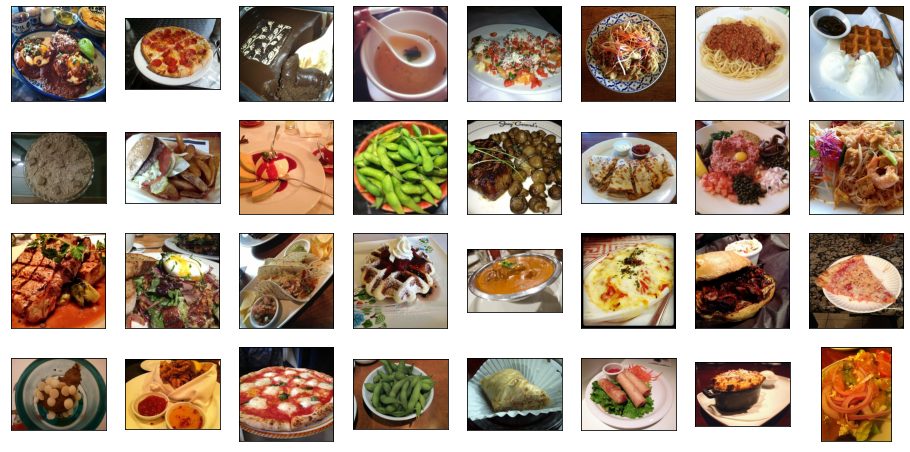

In [5]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

### Создание пайплайна данных

In [0]:
INP_SIZE = 160
NUM_EPOCHS = 20
BATCH_SIZE = 32


def prepare(img, label):
    img = tf.cast(img, tf.float32) / 127. - 1
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

# Аугментация
def augment(img, label):
    img = tf.image.flip_left_right(img) # Зеркальное отображение
    return img, label


train_ds = train_ds.map(prepare)
augm = train_ds.map(augment)
train_ds = train_ds.concatenate(augm)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.map(prepare)
test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.batch(128, drop_remainder=True)

### Подготовка модели CNN

In [7]:
# Transfer learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[INP_SIZE, INP_SIZE, 3],
    include_top=False,
    weights='imagenet'
)

base_model.trainable=True

model = tf.keras.Sequential(
    [base_model,
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(101, activation='softmax')
     ]
)

9412608/9406464 [==============================] - 0s 0us/step


### Подготовка к обучению

In [0]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

model.compile(
    optimizer=optimizer, 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir = 'logs',
    write_graph=False,
    update_freq=100,
    profile_batch=0
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


### Обучение модели

In [10]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/20
4260/4260 [==============================] - 774s 182ms/step - loss: 1.7086 - accuracy: 0.5711 - val_loss: 1.4136 - val_accuracy: 0.6312
Epoch 2/20
4260/4260 [==============================] - 794s 186ms/step - loss: 0.8883 - accuracy: 0.7597 - val_loss: 1.3432 - val_accuracy: 0.6517
Epoch 3/20
4260/4260 [==============================] - 790s 185ms/step - loss: 0.5599 - accuracy: 0.8443 - val_loss: 1.4490 - val_accuracy: 0.6427
Epoch 4/20
4260/4260 [==============================] - 808s 190ms/step - loss: 0.3607 - accuracy: 0.8974 - val_loss: 1.4747 - val_accuracy: 0.6555
Epoch 5/20
4260/4260 [==============================] - 784s 184ms/step - loss: 0.2505 - accuracy: 0.9257 - val_loss: 1.6227 - val_accuracy: 0.6498
Epoch 6/20
4260/4260 [==============================] - 794s 186ms/step - loss: 0.1898 - accuracy: 0.9438 - val_loss: 1.6636 - val_accuracy: 0.6434
Epoch 7/20
4260/4260 [==============================] - 796s 187ms/step - loss: 0.1548 - accuracy: 0.9529 - val_

### Оценка качества модели

In [11]:
%%time

model.evaluate(test_ds)

59/59 [==============================] - 20s 347ms/step - loss: 2.2345 - accuracy: 0.6437
CPU times: user 34.3 s, sys: 3.54 s, total: 37.9 s
Wall time: 23.4 s


[2.234462261199951, 0.6436705589294434]